In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os

folder_path = '/content/drive/MyDrive/Coin'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
df_list = []

for file in csv_files:
    df = pd.read_csv(os.path.join(folder_path, file))
    df['Name'] = file.replace('coin_', '').replace('.csv', '')
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

print("Basic Analysis:")
print("Number of Rows and Columns:", combined_df.shape)
print("\nColumns:", combined_df.columns)
print("\nData Types:\n", combined_df.dtypes)
print("\nSummary Statistics:\n", combined_df.describe())

aave_df = combined_df[combined_df['Name'].str.lower() == 'aave'].copy()

aave_df['Date'] = pd.to_datetime(aave_df['Date'])
aave_df['Close_Next_Day'] = aave_df['Close'].shift(-1)
aave_df.dropna(inplace=True)

print("\nAave DataFrame:")
print(aave_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Basic Analysis:
Number of Rows and Columns: (36807, 10)

Columns: Index(['SNo', 'Name', 'Symbol', 'Date', 'High', 'Low', 'Open', 'Close',
       'Volume', 'Marketcap'],
      dtype='object')

Data Types:
 SNo            int64
Name          object
Symbol        object
Date          object
High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Marketcap    float64
dtype: object

Summary Statistics:
                 SNo          High           Low          Open         Close  \
count  36807.000000  36807.000000  36807.000000  36807.000000  36807.000000   
mean    1063.562991   1021.622354    958.331642    990.783986    992.586551   
std      754.582253   5268.660933   4925.824861   5106.661376   5112.284493   
min        1.000000      0.000089      0.000079      0.000086      0.000086   
25%      430.000000      

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📊 Testing on Bitcoin dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
📉 MSE for Bitcoin: 0.00011


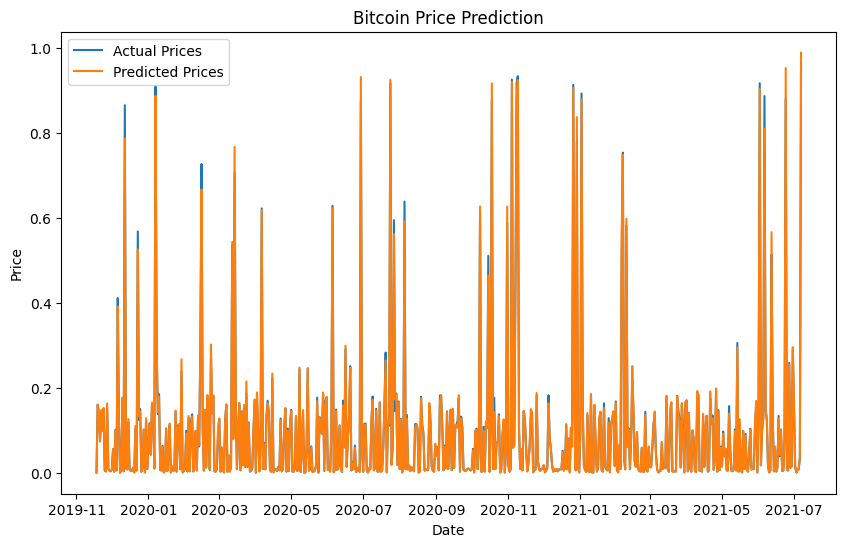


📊 Testing on Ethereum dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📉 MSE for Ethereum: 0.00013


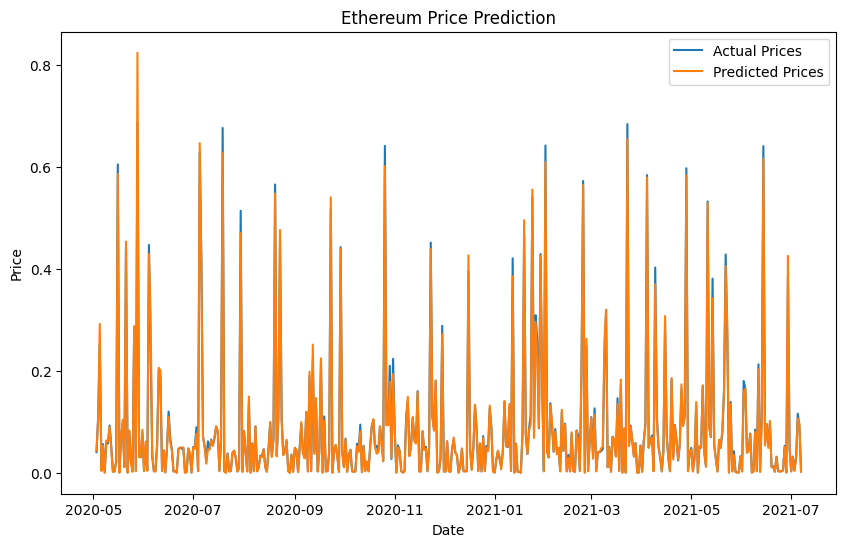


📊 Testing on Litecoin dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
📉 MSE for Litecoin: 0.00014


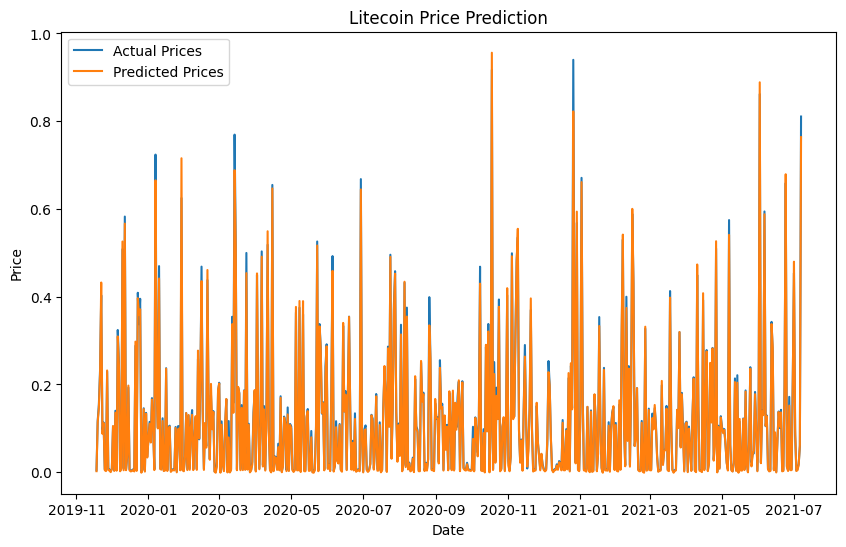

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

🧠 MSE for Combined Coins: 0.00014


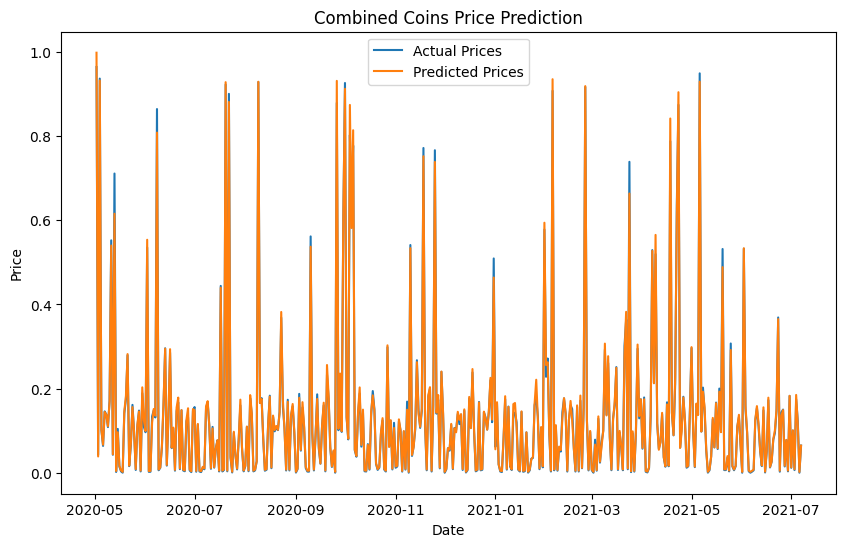

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

def create_features_and_target(data, lag_features, close_column):
    for lag in lag_features:
        data[f'lag_{lag}'] = data[close_column].shift(lag)
    data.dropna(inplace=True)
    X = data[[f'lag_{lag}' for lag in lag_features]]
    y = data[close_column]
    return X, y

def reshape_for_lstm(X, y, n_steps=1):
    features = X.shape[1]
    if features % n_steps != 0:
        additional_features = n_steps - (features % n_steps)
        X = pd.concat([X, pd.DataFrame(X.iloc[:, -additional_features:].values)], axis=1)
    features = X.shape[1]
    X = X.values.reshape((X.shape[0], n_steps, features // n_steps))
    y = y.values.reshape((y.shape[0], 1))
    return X, y

def train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, n_steps=1, epochs=50):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

def plot_predictions(y_true, y_pred, coin_name, original_index):
    plt.figure(figsize=(10, 6))
    plt.plot(original_index, y_true, label='Actual Prices')
    plt.plot(original_index, y_pred, label='Predicted Prices')
    plt.title(f'{coin_name} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

directory_path = '/content/drive/MyDrive/Coin'
coins = ['Bitcoin', 'Ethereum', 'Litecoin']
lag_features = [1, 2, 3, 4, 5]

for coin in coins:
    print(f"\n📊 Testing on {coin} dataset:")
    file_path = os.path.join(directory_path, f'coin_{coin}.csv')
    data = load_and_preprocess_data(file_path)

    X, y = create_features_and_target(data, lag_features, close_column=data.columns[3])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

    X_lstm, y_lstm = reshape_for_lstm(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), n_steps=3)

    X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

    mse, predictions = train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, n_steps=3)
    print(f'📉 MSE for {coin}: {mse:.5f}')

    plot_predictions(y_test, predictions, coin, data.index[-len(y_test):])

def load_and_preprocess_all_coins(directory_path, coins):
    all_coins_df = pd.DataFrame()
    for coin in coins:
        file_path = os.path.join(directory_path, f'coin_{coin}.csv')
        data = load_and_preprocess_data(file_path)
        all_coins_df[f'{coin}'] = data[data.columns[3]]
    return all_coins_df

def load_and_preprocess_random_coins(directory_path, coins):
    random_coins_df = pd.DataFrame()
    for coin in coins:
        file_path = os.path.join(directory_path, f'coin_{coin}.csv')
        data = load_and_preprocess_data(file_path)
        random_coins_df[f'{coin}_shuffled'] = data.sample(frac=1)[data.columns[3]]
    return random_coins_df

all_coins_df = load_and_preprocess_all_coins(directory_path, coins)
random_coins_df = load_and_preprocess_random_coins(directory_path, coins)
all_data = pd.concat([all_coins_df, random_coins_df], axis=1)

X, y = create_features_and_target(all_data, lag_features=[1,2,3], close_column=all_data.columns[0])
scaler_combined = MinMaxScaler()
X_scaled = scaler_combined.fit_transform(X)
y_scaled = scaler_combined.fit_transform(y.values.reshape(-1, 1))

X_lstm, y_lstm = reshape_for_lstm(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), n_steps=3)
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

mse_combined, predictions_combined = train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, n_steps=3)
print(f'\n🧠 MSE for Combined Coins: {mse_combined:.5f}')
plot_predictions(y_test, predictions_combined, 'Combined Coins', all_data.index[-len(y_test):])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

📊 Testing on Dogecoin dataset:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📉 Mean Squared Error for Dogecoin: 0.00046


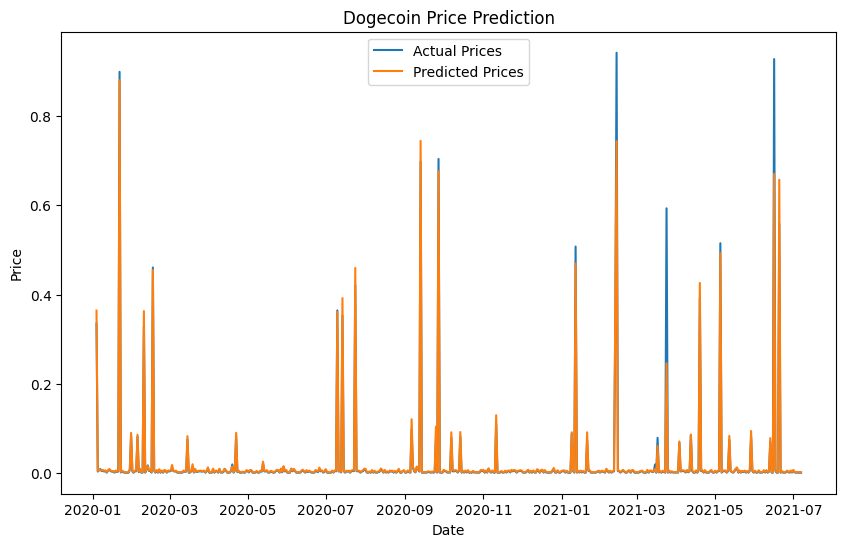

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

def create_features_and_target(data, lag_features, close_column):
    for lag in lag_features:
        data[f'lag_{lag}'] = data[close_column].shift(lag)
    data.dropna(inplace=True)
    X = data[[f'lag_{lag}' for lag in lag_features]]
    y = data[close_column]
    return X, y

def reshape_for_lstm(X, y, n_steps=1):
    features = X.shape[1]
    if features % n_steps != 0:
        additional_features = n_steps - (features % n_steps)
        X = pd.concat([X, pd.DataFrame(X.iloc[:, -additional_features:].values)], axis=1)
    features = X.shape[1]
    X = X.values.reshape((X.shape[0], n_steps, features // n_steps))
    y = y.values.reshape((y.shape[0], 1))
    return X, y

def train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, n_steps=1, epochs=50):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse, y_pred

def plot_predictions(y_true, y_pred, coin_name, original_index):
    plt.figure(figsize=(10, 6))
    plt.plot(original_index, y_true, label='Actual Prices')
    plt.plot(original_index, y_pred, label='Predicted Prices')
    plt.title(f'{coin_name} Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

coin_name = 'Dogecoin'
directory_path = '/content/drive/MyDrive/Coin'
file_path = os.path.join(directory_path, f'coin_{coin_name}.csv')
lag_features = [1, 2, 3, 4, 5]

print(f"\n📊 Testing on {coin_name} dataset:")
data = load_and_preprocess_data(file_path)

X, y = create_features_and_target(data, lag_features, close_column=data.columns[3])

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_lstm, y_lstm = reshape_for_lstm(pd.DataFrame(X_scaled), pd.DataFrame(y_scaled), n_steps=3)

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

mse, predictions = train_and_evaluate_lstm_model(X_train, y_train, X_test, y_test, n_steps=3)
print(f'📉 Mean Squared Error for {coin_name}: {mse:.5f}')

plot_predictions(y_test, predictions, coin_name, data.index[-len(y_test):])
